### This notebook demonstrates how to use unfolding with the Python version of the BDT OmniFold
#### While the main software uses the RooUnfoldOmnifold class in RooUnfold, it uses Python behind in the scenes. This notebook accesses those functions directly

#### In this notebook, we'll focus on unbinned unfolding. We'll first generate the data and then do unbinned unfolding.
#### Unbinned unfolding uses lists of data. We'll use NumPy arrays for this.

#### We'll still use ROOT to generate the data to be consistent with the other notebook (OmniFold_example.ipynb)

In [1]:
import ROOT
import numpy as np
import sys
sys.path.append('../build/RooUnfold/') # Insert path to your build directory
from omnifold import OmniFold_helper_functions

import matplotlib.pyplot as plt

### We'll now generate the data. This follows the generation from [the RooUnfold tutorial](https://statisticalmethods.web.cern.ch/StatisticalMethods/unfolding/RooUnfold_01-Methods/).

In [2]:
def smear(xt):
  xeff = 0.3 + (1.0-0.3)/20*(xt+10.0)  #  efficiency                                                                                  
  x = ROOT.gRandom.Rndm()
  if x>xeff: return None
  xsmear = ROOT.gRandom.Gaus(-2.5,0.2)     #  bias and smear 
  return xt + xsmear

In [3]:
# Number of data points we'll generate
num_MC_data = 100000
num_truth_data = 10000

# Defining the binning we'll use in our plots
MCreco_bins, MCreco_low, MCreco_high  = 40, -10, 10
MCgen_bins, MCgen_low, MCgen_high = 40, -10, 10
truth_bins, truth_low, truth_high = 40, -10, 10
measured_bins, measured_low, measured_high = 40, -10, 10

# These lists will contain the unbinned data, i.e. the data without being put into a histogram
unbinned_MCgen = []
unbinned_MCreco = []
unbinned_truth = []
unbinned_measured = []
MC_pass_reco = []
MC_pass_gen = []
measured_pass_reco = []

### Creating unbinned data

In [4]:
# Generating pseudodata
# For readability, we'll populate the unbinned entries and bin them afterwards

# Generating MC data
for i in range(num_MC_data):
    xt = ROOT.gRandom.BreitWigner(0.3, 2.5)
    unbinned_MCgen.append(xt)
        
    # To demonstrate cuts on the true MC data, we'll make a cut on whether the data falls within the histogram bin range
    if xt < MCgen_low or xt > MCgen_high:
        MC_pass_gen.append(False)
    else:
        MC_pass_gen.append(True)

    # Smearing the MC data to imitate reconstruction
    x = smear(xt)
    if x != None:
        unbinned_MCreco.append(x)
        MC_pass_reco.append(True)
    else:
        # Note that the unbinned data should have the same length for the MC truth and MC reco (sim) data
        # So for events that don't pass reconstruction, a placeholder value should be used
        unbinned_MCreco.append(-9999)
        MC_pass_reco.append(False)

# Generating truth/measured data
for i in range(num_truth_data):
    xt = ROOT.gRandom.Gaus (0.0, 2.0)
    unbinned_truth.append(xt)
    
    x = smear(xt)
    if x != None:
        unbinned_measured.append(x)
        measured_pass_reco.append(True)
    else:
        unbinned_measured.append(-9999)
        measured_pass_reco.append(False)
        
# We'll now convert these to numpy arrays, which will act as input to the unbinned unfolding functions
unbinned_MCgen = np.array(unbinned_MCgen, dtype = np.float32)
unbinned_MCreco = np.array(unbinned_MCreco, dtype = np.float32)
unbinned_truth = np.array(unbinned_truth, dtype = np.float32)
unbinned_measured = np.array(unbinned_measured, dtype = np.float32)
MC_pass_reco = np.array(MC_pass_reco, dtype=bool)
MC_pass_gen = np.array(MC_pass_gen, dtype=bool)
measured_pass_reco = np.array(measured_pass_reco, dtype=bool)

### Doing unfolding

In [5]:
number_of_iterations = 4
model_save_parameters = {
    "save_models" : True,
    "save_dir": "./",
    "model_save_name": "unbinned_unfolding_example"
}

In [6]:
step1_weights, step2_weights = OmniFold_helper_functions.unbinned_omnifold(
    MCgen_entries = unbinned_MCgen,
    MCreco_entries = unbinned_MCreco,
    measured_entries = unbinned_measured,
    MC_pass_reco_mask = MC_pass_reco,
    MC_pass_truth_mask = MC_pass_gen,
    measured_pass_reco_mask = measured_pass_reco, 
    num_iterations = number_of_iterations,
    model_save_dict = model_save_parameters
)

Starting iteration 0
Saved models for iteration 0 to ./unbinned_unfolding_example_iteration_0.pkl
Starting iteration 1
Saved models for iteration 1 to ./unbinned_unfolding_example_iteration_1.pkl
Starting iteration 2
Saved models for iteration 2 to ./unbinned_unfolding_example_iteration_2.pkl
Starting iteration 3
Saved models for iteration 3 to ./unbinned_unfolding_example_iteration_3.pkl


### Plotting the results
#### To do this, just apply the step 2 weights to the MCgen distribution. If you have a MC_pass_gen mask, then you should apply it to your data

Text(0.5, 0, 'x')

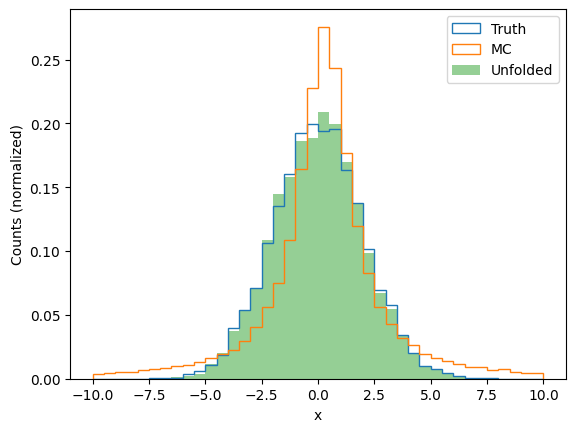

In [7]:
fig = plt.figure()
plt.hist(unbinned_truth, bins = truth_bins, range = (truth_low, truth_high), density = True, label = "Truth", histtype='step')
plt.hist(unbinned_MCgen[MC_pass_gen], bins = MCgen_bins, range = (MCgen_low, MCgen_high), density = True, label = "MC", histtype='step')
plt.hist(unbinned_MCgen[MC_pass_gen], weights = step2_weights, bins = MCgen_bins, range = (MCgen_low, MCgen_high), density = True, label = "Unfolded", histtype='stepfilled', alpha=.5)
plt.legend()
plt.ylabel("Counts (normalized)")
plt.xlabel("x")

#### With this class, there's boosted decision trees under the hood
#### We can control the parameters of these decision trees using dictionaries in Python.
#### Note for the C++ version, we used TMaps. Changing the parameters is simpler in Python
#### The available parameters are found in the scikit-learn pages for [GradientBoostingClassifier](https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) and [GradientBoostingRegressor](https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html).
#### We'll adjust the n_estimators parameter

In [8]:
step1_classifier_parameters = {"n_estimators" : 50}
step2_classifier_parameters = {"n_estimators" : 50}
step1_regressor_parameters  = {"n_estimators" : 50}
model_save_parameters = {
    "save_models" : True,
    "save_dir": "./",
    "model_save_name": "unbinned_unfolding_example_50nestimators"
}

In [9]:
step1_weights, step2_weights = OmniFold_helper_functions.unbinned_omnifold(
    MCgen_entries = unbinned_MCgen,
    MCreco_entries = unbinned_MCreco,
    measured_entries = unbinned_measured,
    MC_pass_reco_mask = MC_pass_reco,
    MC_pass_truth_mask = MC_pass_gen,
    measured_pass_reco_mask = measured_pass_reco, 
    num_iterations = number_of_iterations,
    model_save_dict = model_save_parameters,
    classifier1_params = step1_classifier_parameters,
    classifier2_params = step2_classifier_parameters,
    regressor_params = step1_regressor_parameters,
    parameter_format = "dict", # Instead of TMap like the C++ version of the code
)

Starting iteration 0
Saved models for iteration 0 to ./unbinned_unfolding_example_50nestimators_iteration_0.pkl
Starting iteration 1
Saved models for iteration 1 to ./unbinned_unfolding_example_50nestimators_iteration_1.pkl
Starting iteration 2
Saved models for iteration 2 to ./unbinned_unfolding_example_50nestimators_iteration_2.pkl
Starting iteration 3
Saved models for iteration 3 to ./unbinned_unfolding_example_50nestimators_iteration_3.pkl


Text(0.5, 0, 'x')

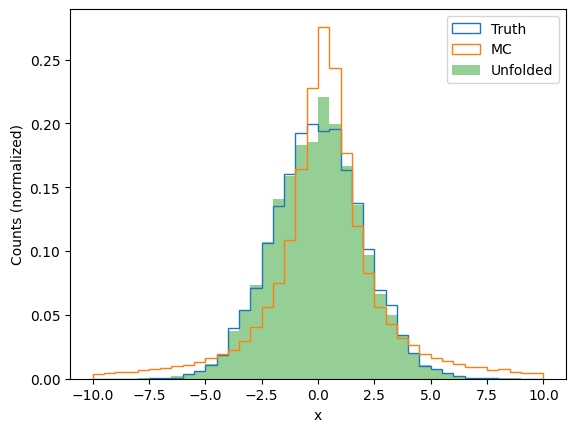

In [10]:
fig = plt.figure()
plt.hist(unbinned_truth, bins = truth_bins, range = (truth_low, truth_high), density = True, label = "Truth", histtype='step')
plt.hist(unbinned_MCgen[MC_pass_gen], bins = MCgen_bins, range = (MCgen_low, MCgen_high), density = True, label = "MC", histtype='step')
plt.hist(unbinned_MCgen[MC_pass_gen], weights = step2_weights, bins = MCgen_bins, range = (MCgen_low, MCgen_high), density = True, label = "Unfolded", histtype='stepfilled', alpha=.5)
plt.legend()
plt.ylabel("Counts (normalized)")
plt.xlabel("x")

### We'll now demonstrate loading a model and have it produce weights for a set of events
#### For this demonstration, we'll use half of the MC dataset for training and the other half for testing

In [11]:
num_split_data = int(num_MC_data/2)
unbinned_MCgen_train = unbinned_MCgen[:num_split_data]
unbinned_MCreco_train = unbinned_MCreco[:num_split_data]
MC_pass_reco_train = MC_pass_reco[:num_split_data]
MC_pass_gen_train = MC_pass_gen[:num_split_data]

unbinned_MCgen_test = unbinned_MCgen[num_split_data:]
unbinned_MCreco_test = unbinned_MCreco[num_split_data:]
MC_pass_reco_test = MC_pass_reco[num_split_data:]
MC_pass_gen_test = MC_pass_gen[num_split_data:]

# During training, the events that don't pass gen are removed. So during testing, we'll remove these events beforehand
unbinned_MCgen_test = unbinned_MCgen_test[MC_pass_gen_test]
unbinned_MCreco_test = unbinned_MCreco_test[MC_pass_gen_test]
MC_pass_reco_test = MC_pass_reco_test[MC_pass_gen_test]

model_save_parameters = {
    "save_models" : True,
    "save_dir": "./",
    "model_save_name": "unbinned_unfolding_example_traintestsplit"
}

In [12]:
# We only care about the weights for the test data, so throw away the weights that come from training
_, _ = OmniFold_helper_functions.unbinned_omnifold(
    MCgen_entries = unbinned_MCgen_train,
    MCreco_entries = unbinned_MCreco_train,
    measured_entries = unbinned_measured,
    MC_pass_reco_mask = MC_pass_reco_train,
    MC_pass_truth_mask = MC_pass_gen_train,
    measured_pass_reco_mask = measured_pass_reco,
    num_iterations = number_of_iterations,
    model_save_dict = model_save_parameters,
)

Starting iteration 0
Saved models for iteration 0 to ./unbinned_unfolding_example_traintestsplit_iteration_0.pkl
Starting iteration 1
Saved models for iteration 1 to ./unbinned_unfolding_example_traintestsplit_iteration_1.pkl
Starting iteration 2
Saved models for iteration 2 to ./unbinned_unfolding_example_traintestsplit_iteration_2.pkl
Starting iteration 3
Saved models for iteration 3 to ./unbinned_unfolding_example_traintestsplit_iteration_3.pkl


In [13]:
print("Performing predictions")
iteration_to_load = 4
model_path = f"./unbinned_unfolding_example_traintestsplit_iteration_{iteration_to_load-1}.pkl"
step1_weights = OmniFold_helper_functions.get_step1_predictions(unbinned_MCgen_test, unbinned_MCreco_test, model_path, MC_pass_reco_test)
step2_weights = OmniFold_helper_functions.get_step2_predictions(unbinned_MCgen_test, model_path)

Performing predictions
Opening ./unbinned_unfolding_example_traintestsplit_iteration_3.pkl for step 1 predictions.
Opening ./unbinned_unfolding_example_traintestsplit_iteration_3.pkl for step 2 predictions.


Text(0.5, 0, 'x')

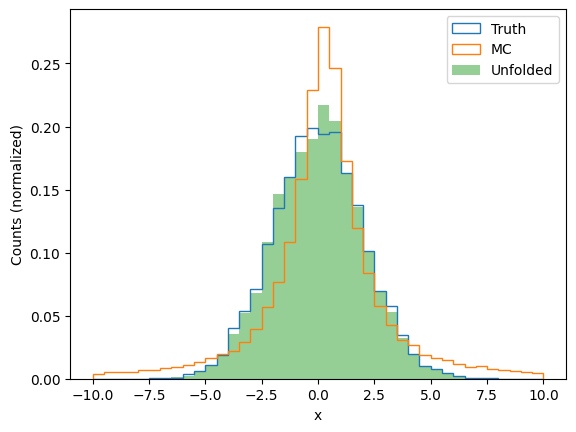

In [14]:
fig = plt.figure()
plt.hist(unbinned_truth, bins = truth_bins, range = (truth_low, truth_high), density = True, label = "Truth", histtype='step')
plt.hist(unbinned_MCgen_test, bins = MCgen_bins, range = (MCgen_low, MCgen_high), density = True, label = "MC", histtype='step')
plt.hist(unbinned_MCgen_test, weights = step2_weights, bins = MCgen_bins, range = (MCgen_low, MCgen_high), density = True, label = "Unfolded", histtype='stepfilled', alpha=.5)
plt.legend()
plt.ylabel("Counts (normalized)")
plt.xlabel("x")

### We'll also demonstrate reweighting our reco distribution to the actual reco distribution. The first iteration should be used for this
#### For this, we'll use the model we just trained

In [15]:
print("Performing predictions")
iteration_to_load = 1
model_path = f"./unbinned_unfolding_example_traintestsplit_iteration_{iteration_to_load-1}.pkl"
step1_weights = OmniFold_helper_functions.get_step1_predictions(unbinned_MCgen_test, unbinned_MCreco_test, model_path, MC_pass_reco_test)

Performing predictions
Opening ./unbinned_unfolding_example_traintestsplit_iteration_0.pkl for step 1 predictions.


Text(0.5, 0, 'x')

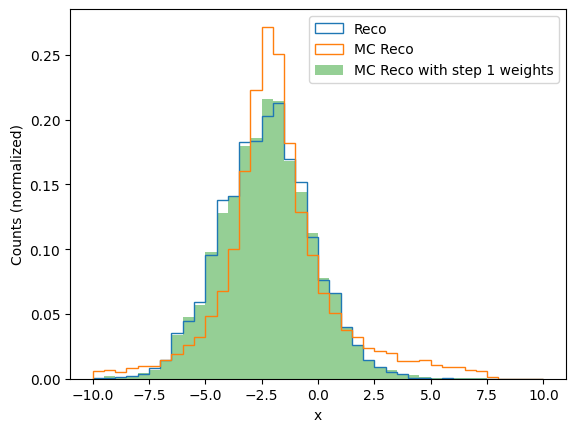

In [16]:
fig = plt.figure()
plt.hist(unbinned_measured, bins = measured_bins, range = (measured_low, measured_high), density = True, label = "Reco", histtype='step')
plt.hist(unbinned_MCreco_test, bins = MCreco_bins, range = (MCreco_low, MCreco_high), density = True, label = "MC Reco", histtype='step')
plt.hist(unbinned_MCreco_test, weights = step1_weights, bins = MCreco_bins, range = (MCreco_low, MCreco_high), density = True, label = "MC Reco with step 1 weights", histtype='stepfilled', alpha=.5)
plt.legend()
plt.ylabel("Counts (normalized)")
plt.xlabel("x")